## Computing with NumPy arrays

> **This is an excerpt from [Learning IPython for Interactive Computing and Data Visualization, second edition](http://ipython-books.github.io/minibook/).**
>
> Previously in this Chapter 3, we analyzed trip and fare data of nearly one million NYC taxi journeys. Here, we make a density plot of evening trips in Manhattan. In order to run this notebook locally, you'll need to download the `nyc_taxi` dataset from [the data repo](https://github.com/ipython-books/minibook-2nd-data), and extract it to `../chapter2/data/nyc_data.csv` (or just change the path in the second code cell below).

We now get to the substance of array programming with NumPy. We will perform  manipulations and computations on ndarrays.

Let's first import NumPy, pandas, matplotlib, and seaborn:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib; matplotlib.rcParams['savefig.dpi'] = 144

We load the NYC taxi dataset with pandas:

In [2]:
data = pd.read_csv('../chapter2/data/nyc_data.csv',
                   parse_dates=['pickup_datetime', 'dropoff_datetime'])

We get the pickup and dropoff locations of the taxi rides as ndarrays, using the `.values` attribute of pandas DataFrames:

In [3]:
pickup = data[['pickup_longitude', 'pickup_latitude']].values
dropoff = data[['dropoff_longitude', 'dropoff_latitude']].values
pickup

array([[-73.955925,  40.781887],
       [-74.005501,  40.745735],
       [-73.969955,  40.79977 ],
       ..., 
       [-73.993492,  40.729347],
       [-73.978477,  40.772945],
       [-73.987206,  40.750568]])

### Selection and indexing

Let's illustrate selection and indexing with NumPy. These operations are similar to those offered by pandas on DataFrame and Series objects.

In NumPy, a given element can be retrieved with `pickup[i, j]`, where `i` is the 0-indexed row number, and `j` is the 0-indexed column number:

In [4]:
print(pickup[3, 1])

40.755081


A part of the array can be selected with the slicing syntax, which supports a start position, an end position, and an optional step, as shown here:

In [5]:
pickup[1:7:2, 1:]

array([[ 40.745735],
       [ 40.755081],
       [ 40.768978]])

Here, we've selected the elements at `[1, 1]`, `[3, 1]`, and `[5, 1]`. The slicing syntax in Python is `start:end:step` where `start` is included and `end` is excluded. If `start` or `end` are omitted, they default to `0` or the length of the dimension, respectively, whereas `step` defaults to 1. For example, `1:` is equivalent to `1:n:1` where `n` is the size of the axis.

Let's select the longitudes of all pickup locations, in other words, the first column:

In [6]:
lon = pickup[:, 0]
lon

array([-73.955925, -74.005501, -73.969955, ..., -73.993492, -73.978477,
       -73.987206])

The result is a 1D ndarray.

We also get the second column of `pickup`:

In [7]:
lat = pickup[:, 1]
lat

array([ 40.781887,  40.745735,  40.79977 , ...,  40.729347,  40.772945,
        40.750568])

### Boolean operations on arrays

Let's now illustrate filtering operations in NumPy. Again, these are similar to pandas. As an example, we're going to select all trips departing at a given location:

In [8]:
lon_min, lon_max = (-73.98330, -73.98025)
lat_min, lat_max = ( 40.76724,  40.76871)

In NumPy, symbols like arithmetic, inequality, and boolean operators work on ndarrays on an element-wise basis. Here is how to select all trips where the longitude is between `lon_min` and `lon_max`:

In [9]:
in_lon = (lon_min <= lon) & (lon <= lon_max)
in_lon

array([False, False, False, ..., False, False, False], dtype=bool)

The symbol `&` represents the AND boolean operator, while `|` represents the OR.

Here, the result is a Boolean vector containing as many elements as there are in the `lon` vector.

How many `True` elements are there in this array? NumPy arrays provide a `sum()` method that returns the sum of all elements in the array. When the array contains boolean values, `False` elements are converted to 0 and `True` elements are converted to 1. Therefore, the sum corresponds to the number of `True` elements:

In [10]:
in_lon.sum()

69163

We can process the latitudes similarly:

In [11]:
in_lat = (lat_min <= lat) & (lat <= lat_max)

Then, we get all trips where both the longitude and latitude belong to our rectangle:

In [12]:
in_lonlat = in_lon & in_lat
in_lonlat.sum()

3998

The `np.nonzero()` function returns the indices corresponding to `True` in a boolean array, as shown here:

In [13]:
np.nonzero(in_lonlat)[0]

array([   901,   1011,   1066, ..., 845749, 845903, 846080])

Finally, we'll need the dropoff coordinates in the following:

In [14]:
lon1, lat1 = dropoff.T

This is a more concise way of writing `lon1 = dropoff[:, 0]; lat1 = dropoff[:, 1]`. The `T` attribute corresponds to the transpose of a matrix, which simply means that a matrix's columns become the corresponding rows of a new matrix, just as the new columns are the original matrix's rows. Here, `dropoff.T` is a `(2, N)` array where the first row contains the longitude and the second row contains the latitude. In NumPy, an ndarray is iterable along the first dimension, in other words, along the rows of the matrix. Therefore, the syntax unpacking feature of Python allows us to concisely assign `lon1` to the first row and `lat1` to the second row.

### Mathematical operations on arrays

We have the coordinates of all pickup and dropoff locations in NumPy arrays. Let's compute the straight line distance between those two locations, for every taxi trip.

There are several mathematical formulas giving the distance between two points given by their longitudes and latitudes. Here, we will compute a great-circle distance with a spherical Earth approximation.

The following function implements this formula.

In [15]:
EARTH_R = 6372.8
def geo_distance(lon0, lat0, lon1, lat1):
    """Return the distance (in km) between two points in
    geographical coordinates."""
    # from: http://en.wikipedia.org/wiki/Great-circle_distance
    # and: http://stackoverflow.com/a/8859667/1595060
    lat0 = np.radians(lat0)
    lon0 = np.radians(lon0)
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    dlon = lon0 - lon1
    y = np.sqrt(
        (np.cos(lat1) * np.sin(dlon)) ** 2
         + (np.cos(lat0) * np.sin(lat1)
         - np.sin(lat0) * np.cos(lat1) * np.cos(dlon)) ** 2)
    x = np.sin(lat0) * np.sin(lat1) + \
        np.cos(lat0) * np.cos(lat1) * np.cos(dlon)
    c = np.arctan2(y, x)
    return EARTH_R * c

We have made extensive use of trigonometric functions provided by NumPy: `np.radians()` (converting numbers from degrees into radians), `np.cos()`, `np.sin()`, `np.arctan2(x, y)` (returning the arctangent of `x/y`), and so on. These mathematical functions are defined on real numbers, but NumPy provides *vectorized* versions of them. These vectorized functions not only work on numbers but also on arbitrary numerical ndarrays. As we have explained earlier, these functions are orders of magnitude faster than Python loops. You will find the list of mathematical functions in NumPy at http://docs.scipy.org/doc/numpy/reference/routines.math.html.

All in all, NumPy makes it quite natural to implement mathematical formulas on arrays of numbers. The syntax is exactly the same as with scalar operations.

Now, let's compute the straight line distances of all taxi trips:

In [16]:
distances = geo_distance(lon, lat, lon1, lat1)

Below is a histogram of these distances for the trips starting at Columbus Circle (the location indicated by the geographical coordinates above). Those trips are indicated by the `in_lonlat` boolean array obtained earlier in this section.

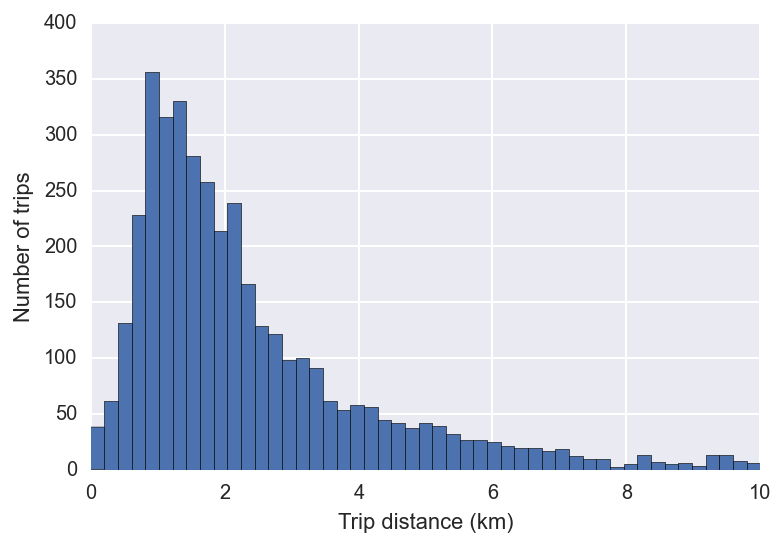

In [18]:
plt.hist(distances[in_lonlat], np.linspace(0., 10., 50))
plt.xlabel('Trip distance (km)')
plt.ylabel('Number of trips')

matplotlib's `plt.hist()` function computes a histogram and plots it. It is a convenient wrapper around NumPy's `np.histogram()` function that just computes a histogram. You will find more statistical functions in NumPy at http://docs.scipy.org/doc/numpy/reference/routines.statistics.html.

### A density map with NumPy

We have reviewed the most common array operations in this section. We will now see a more advanced example combining several techniques. We will compute and display a 2D density map of the most common pickup and dropoff locations, at specific times in the day.

First, let's select the evening taxi trips. This time, we use pandas, which offers particularly rich date and time features. We eventually get a NumPy array with the `.values` attribute:

In [19]:
evening = (data.pickup_datetime.dt.hour >= 19).values

In [20]:
n = np.sum(evening)

In [21]:
n

242818

> TIP (Pandas and NumPy): Remember that pandas is based on NumPy, and that it is quite common to leverage both libraries in complex data analysis tasks. A natural workflow is to start loading and manipulating data with pandas, and then switch to NumPy when complex mathematical operations are to be performed on arrays. As a rule of thumb, pandas excels at filtering, selecting, grouping, and other data manipulations, whereas NumPy is particularly efficient at vector mathematical operations on numerical arrays.

The `n` variable contains the number of evening trips in our dataset.

Here is how we are going to create our density map: We consider the set of all pickup and dropoff locations for these `n` evening trips. There are `2n` of such points. Every point is associated with a weight of `-1` for pickup locations and `+1` for dropoff locations. The algebraic density of points at a given location, taking into account the weights, reflects whether people tend to leave or to arrive at this location.

To create the `weights` vector for our `2n` points, we first create a vector containing only zeros. Then, we set the first half of the array to `-1` (pickup) and the last half to `+1` (dropoff):

In [22]:
weights = np.zeros(2 * n)

In [23]:
weights[:n] = -1
weights[n:] = +1

> INFO (Indexing in NumPy): Indexing in Python and NumPy starts at 0, and excludes the last element. The first half of `weights` is made of `weights[0]`, `weights[1]`, up to `weights[n-1]`. There are `n` of such elements. The slice `weights[:n]` is equivalent to `weights[0:n]`: it starts at `weights[0]`, and ends at `weights[n]` *excluded*, so the last element is effectively `weights[n-1]`.

We could also have used array manipulation routines provided by NumPy, such as `np.tile()` to concatenate copies of an array along several dimensions, or `np.repeat()` to make copies of every element along several dimensions. You will find the list of manipulation functions at http://docs.scipy.org/doc/numpy/reference/routines.array-manipulation.html.

Next, we create a `(2n, 2)` array defined by the vertical concatenation of the pickup and dropoff locations for the evening trips:

In [24]:
points = np.r_[pickup[evening],
               dropoff[evening]]

In [25]:
points.shape

(485636, 2)

The concise `np.r_[]` syntax allows us to concatenate arrays along the first (vertical) dimension. We could also have used more explicit manipulation functions such as `np.vstack()` or `np.concatenate()`.

Now, we convert these points from geographical coordinates to pixel coordinates, using the same function as in the previous chapter.

In [26]:
def lat_lon_to_pixels(lat, lon):
    lat_rad = lat * np.pi / 180.0
    lat_rad = np.log(np.tan((lat_rad + np.pi / 2.0) / 2.0))
    x = 100 * (lon + 180.0) / 360.0
    y = 100 * (lat_rad - np.pi) / (2.0 * np.pi)
    return (x, y)

In [27]:
lon, lat = points.T
x, y = lat_lon_to_pixels(lat, lon)

We now define the bins for the 2D histogram in our density map. This defines a 2D grid over which to compute the histogram.

In [28]:
lon_min, lat_min = -74.0214, 40.6978
lon_max, lat_max = -73.9524, 40.7982

In [29]:
x_min, y_min = lat_lon_to_pixels(lat_min, lon_min)
x_max, y_max = lat_lon_to_pixels(lat_max, lon_max)

In [30]:
bin = .00003
bins_x = np.arange(x_min, x_max, bin)
bins_y = np.arange(y_min, y_max, bin)

These two arrays contain the horizontal and vertical bins.

Finally, we compute the histogram with the `np.histogram2d()` function. We pass as arguments the `y, x` coordinates of the points (reversed because we want the grid's first axis to represent the `y` coordinate), the weights, and the bins. This function computes a weighted sum of the points, in every bin. It returns several objects, the first of which is the density map we are interested in:

In [31]:
grid, _, _ = np.histogram2d(y, x, weights=weights,
                            bins=(bins_y, bins_x))

You will find the reference documentation of this function at http://docs.scipy.org/doc/numpy/reference/generated/numpy.histogram2d.html#numpy.histogram2d.

Before displaying the density map, we will apply a logistic function to it in order to smooth it:

In [32]:
density = 1. / (1. + np.exp(-.5 * grid))

This logistic function is called the **expit function**. It can also be found in the SciPy package at `scipy.special.expit()`. `scipy.special` provides many other special functions such as Bessel functions, Gamma functions, hypergeometric functions, and so on.

Finally, we display the density map with `plt.imshow()`:

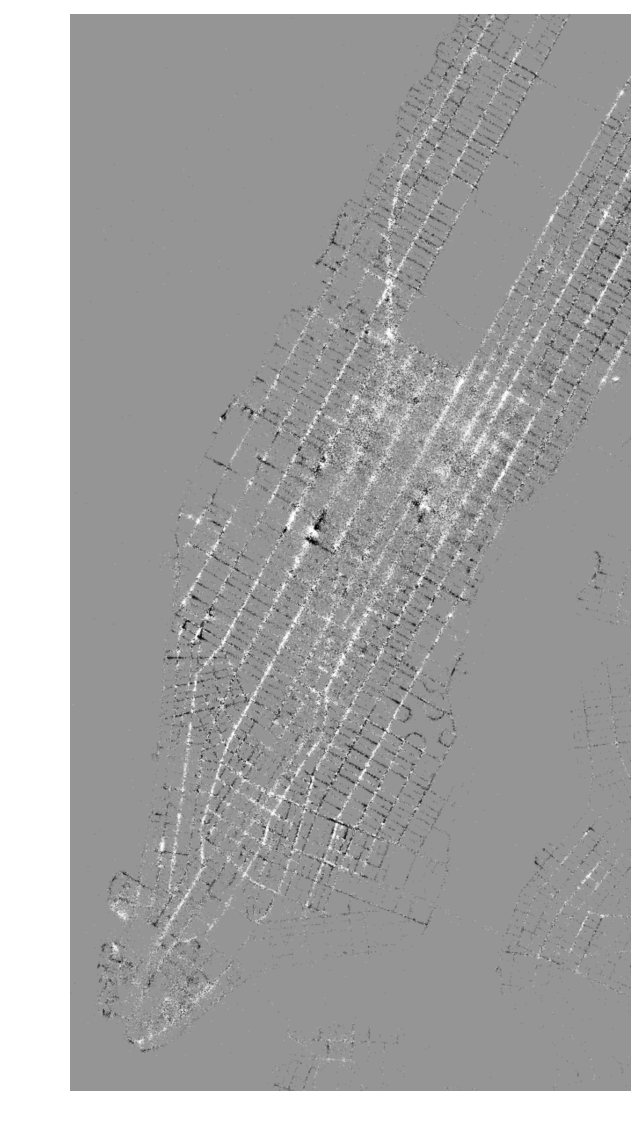

In [33]:
plt.figure(figsize=(8, 8))
plt.imshow(density,
           origin='lower',
           interpolation='bicubic'
           )
plt.axis('off')
plt.tight_layout()

matplotlib's `plt.imshow()` function displays a matrix as an image. It supports several interpolation methods. Here, we used a bicubic interpolation. The `origin` argument is necessary because in our `density` matrix, the top-left corner corresponds to the smallest latitude, so it should correspond to the bottom-left corner in the image.

### Other topics

We only scratched the surface of the possibilities offered by NumPy. Further numerical computing topics covered by NumPy and the more specialized SciPy library include:

* Search and sort in arrays
* Set operations
* Linear algebra
* Special mathematical functions
* Fourier transforms and signal processing
* Generation of pseudo-random numbers
* Statistics
* Numerical integration and numerical ODE solvers
* Function interpolation
* Basic image processing
* Numerical optimization

The IPython Cookbook covers many of these topics.

Here are a few references:

* NumPy reference at http://docs.scipy.org/doc/numpy/reference/
* SciPy reference at http://docs.scipy.org/doc/scipy/reference/
* IPython Cookbook at http://ipython-books.github.io/cookbook/